# Validation of DT Simulation Data with Real Data

Vorgehen:
 Eventlog zeitlich aufsteigen sortieren
 Train,validation und test set bestimmen und mit 1 labeln
 Aufträge aus den Daten generieren Order darf nicht die gesamten Prozessschritte beinhalten Features requested auslesen automatisch => Wie bei Schmaus? Was ist relevantes Features und was sind unwichtige Prozessdaten? TransformationModell soll Feautures entrhalten nur ORders = Aufträge mit sinnvollen Features: Finde sinnvolle Aufträge
Wahrtscheinlich passen die Zeiten aber die exakten Zeitpunkte was mit denen?


Ich konsultiere processed_data.csv um anhand der Case ID einige gesunde Trajektorien herauszufindne und notiere mir das Datum.

Ich muss bestimmte Prozessschritte rausfiltern die nicht zum TransformationModel gehören. 

Gute Trajektorien:

20.04.2022 bis einschl. 22.04.2022
02.05.2022 bis einschl. 19.07.2022
02.11.2022
11.11.2022, 23.11.2022
März 2023 komplett

Maßgeblich für die Mappings sind die Mapping Files aus der Simulation!

Peeking vermeiden: Process Execution ID und Feature Enginnering Variable time since last process ermöglichen peeking! 

## Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load data with process_execution_id as index and proper datetime parsing.


real_data = pd.read_csv(
    r"D:\ofact-intern\projects\iot_factory\val\data\real_factorydata_oclog.csv",
    parse_dates=["start_time", "end_time"],
    index_col="process_execution_id",
)


# NOT THE SAME TIME HORIZON


sim_data = pd.read_csv(
    r"D:\ofact-intern\projects\iot_factory\val\data\simulated_data_oclog.csv",
    parse_dates=["start_time", "end_time"],
    index_col="process_execution_id",
)


# set all is valid values to 0 in sim_data


sim_data["is_valid"] = 0


sim_data["duration"] = sim_data["end_time"] - sim_data["start_time"]


sim_data["duration"] = sim_data["duration"].dt.total_seconds()

## Diskrepanzen bereinigen

### Unify Part IDs

Simulation hat weniger Part IDs als Reale Daten. Standardisiere hier:

In [2]:
def unify_and_drop_part_ids(real_data: pd.DataFrame) -> pd.DataFrame:
    # Define the main mapping (correct mapping)
    main_mapping = {
        "stopper": 0,
        "cover": 1,
        "rass1": 2,
        "analog": 3,
        "gyroscope": 4,
        "rass2": 5,
        "rass3": 6,
        "pcb": 7,
        "display": 8,
    }

    # Define the wrong mapping (current mapping in the data)
    wrong_mapping = {
        "stopper": 0,
        "robot": 1,
        "gyroscope": 2,
        "cover": 3,
        "pcb": 4,
        "display": 5,
        "analog": 6,
        "rass2": 7,
        "rass3": 8,
        "mainpcb": 9,
        "schield": 10,
        "rass1": 11,
        "frontcover": 12,
        "shield": 13,
        "weather": 14,
        "workpiece": 15,
    }

    # Create reverse mapping from wrong mapping: wrong_id -> category
    wrong_mapping_rev = {v: k for k, v in wrong_mapping.items()}

    # Define a function to update the part_id for a row.
    def update_part_id(row):
        wrong_id = row["part_id"]
        # Look up category using wrong_mapping_rev. If not found, return None.
        category = wrong_mapping_rev.get(wrong_id)
        if category is None:
            return None
        # If the category is in the main mapping, return the corresponding id
        if category in main_mapping:
            return main_mapping[category]
        else:
            # Otherwise, return None to indicate the row should be dropped.
            return None

    # Create a new column with the unified part ids.
    real_data["updated_part_id"] = real_data.apply(update_part_id, axis=1)

    # Drop rows where updated_part_id is None (meaning category not in the main mapping)
    unified_data = real_data.dropna(subset=["updated_part_id"]).copy()

    # Convert updated_part_id to integer
    unified_data["updated_part_id"] = unified_data["updated_part_id"].astype(int)

    # Optionally, replace the original part_id with the unified one and drop the temporary column.
    unified_data["part_id"] = unified_data["updated_part_id"]
    unified_data = unified_data.drop(columns=["updated_part_id"])

    return unified_data


real_data = unify_and_drop_part_ids(real_data)

### Type ID unify

In [3]:
def unify_and_drop_process_types(real_data: pd.DataFrame) -> pd.DataFrame:
    # Main (correct) mapping for process_type.
    main_mapping = {"machine": 0, "feature": 1, "endproduct": 2}

    # Wrong mapping from the data.
    wrong_mapping = {
        "machine": 0,
        "endproduct": 1,
        "feature": 2,
        "transport": 3,
        "test": 4,
    }

    # Create a reverse mapping: wrong_id -> category
    wrong_mapping_rev = {v: k for k, v in wrong_mapping.items()}

    # Function to update the process_type for each row.
    def update_process_type(row):
        wrong_id = row["process_type"]
        category = wrong_mapping_rev.get(wrong_id)
        if category is None or category not in main_mapping:
            # Drop row if the category is not in main mapping (i.e., transport, test)
            return None
        return main_mapping[category]

    # Create a new column with unified process_types.
    real_data["updated_process_type"] = real_data.apply(update_process_type, axis=1)

    # Drop rows without a valid unified process_type.
    unified_data = real_data.dropna(subset=["updated_process_type"]).copy()

    # Convert to integer.
    unified_data["updated_process_type"] = unified_data["updated_process_type"].astype(
        int
    )

    # Replace original process_type with the unified value.
    unified_data["process_type"] = unified_data["updated_process_type"]
    unified_data = unified_data.drop(columns=["updated_process_type"])

    return unified_data


real_data = unify_and_drop_process_types(real_data)

### Ressource ID unify

In [4]:
# Define the wrong mapping (used in real data) and create its reverse:
wrong_mapping = {
    "CP-MOBI-WORK-DOCK": 0,
    "CP-F-ASRS20-B": 1,
    "CP-F-ASRS32-P": 2,
    "CP-F-PALROB-B": 3,
    "CP-PICKSORT": 4,
    "CP-AM-CAM": 5,
    "CP-AM-iPICK": 6,
    "CP-F-RASS-1": 7,
    "CP-AM-MEASURE": 8,
    "CP-F-RASS-2": 9,
    "CP-F-RASS-3": 10,
    "CP-AM-FTEST": 11,
    "CP-AM-LABEL": 12,
    "CP-AM-OUT": 13,
    "no resource": 14,
    "CP-F-AASS1": 15,
}
wrong_mapping_rev = {v: k for k, v in wrong_mapping.items()}

# Define the unified mapping based on the main mapping.
# (Note that for mapping from the wrong keys to main IDs, we drop the "_sr name" suffix.)
unified_resource = {
    "CP-F-ASRS32-P": 0,
    "CP-F-RASS-1": 1,
    "CP-AM-MEASURE": 2,
    "CP-F-RASS-2": 3,
    "CP-AM-CAM": 4,
    "CP-F-RASS-3": 5,
    "CP-AM-FTEST": 6,
    "CP-AM-LABEL": 7,
    "CP-AM-OUT": 8,
}


def unify_and_filter_resources(df: pd.DataFrame) -> pd.DataFrame:
    """
    For rows from real data (is_valid==1), convert the resource_id from the wrong mapping to the
    main mapping values. Simulated (is_valid==0) rows should already have correct resource_id values.
    Then drop rows whose resource cannot be unified.
    """

    def update_resource(row):
        # Simulated data (is_valid==0) are assumed to already be using main mapping resource IDs (0-8)
        if row["is_valid"] == 0:
            # Keep the row only if resource_id is in the main mapping (0 through 8).
            if 0 <= row["resource_id"] <= 8:
                return row["resource_id"]
            else:
                return None
        else:
            # For the real data rows: use the wrong mapping to retrieve the resource name,
            # then look it up in the unified_resource mapping.
            wrong_id = row["resource_id"]
            resource_name = wrong_mapping_rev.get(wrong_id)
            if resource_name in unified_resource:
                return unified_resource[resource_name]
            else:
                return None

    df["updated_resource_id"] = df.apply(update_resource, axis=1)
    df = df.dropna(subset=["updated_resource_id"]).copy()
    df["updated_resource_id"] = df["updated_resource_id"].astype(int)
    # Replace the original resource_id with the unified value.
    df["resource_id"] = df["updated_resource_id"]
    df.drop(columns=["updated_resource_id"], inplace=True)
    return df


# Update final_data: keep only rows whose resource can be unified and mapped.
real_data = unify_and_filter_resources(real_data)

## Feature Engineering and finalizing Preprocessing

In [5]:
# Create a mask to select only the desired date ranges:
mask = (
    # 20.04.2022 bis einschl. 22.04.2022
    (
        (real_data["start_time"] >= "2022-04-20")
        & (real_data["start_time"] <= "2022-04-22")
    )
    |
    # 02.05.2022 bis einschl. 19.07.2022
    (
        (real_data["start_time"] >= "2022-05-02")
        & (real_data["start_time"] <= "2022-07-19")
    )
    |
    # 02.11.2022 (only this single day)
    (real_data["start_time"].dt.normalize() == pd.Timestamp("2022-11-02"))
    |
    # 11.11.2022
    (real_data["start_time"].dt.normalize() == pd.Timestamp("2022-11-11"))
    |
    # 23.11.2022
    (real_data["start_time"].dt.normalize() == pd.Timestamp("2022-11-23"))
    |
    # März 2023 komplett – from 2023-03-01 to 2023-03-31 (inclusive)
    (
        (real_data["start_time"] >= "2023-03-01")
        & (real_data["start_time"] < "2023-04-01")
    )
)

# Apply the mask to filter the DataFrame.
filtered_real_data = real_data.loc[mask]


# Concatenate the filtered data with the simulated data.
final_data = pd.concat([filtered_real_data, sim_data]).fillna(0)


# drop process_id > 26
final_data = final_data[final_data["process_id"] <= 26]

# drop part_id = -1
final_data = final_data[final_data["part_id"] != -1]

final_data["sequence_number"] = (
    final_data.sort_values(by=["start_time"]).groupby("process_execution_id").cumcount()
    + 1
)

X = final_data.drop(columns=["is_valid", "start_time", "end_time", "order_id"])
y = final_data["is_valid"]

## Check duration distribution

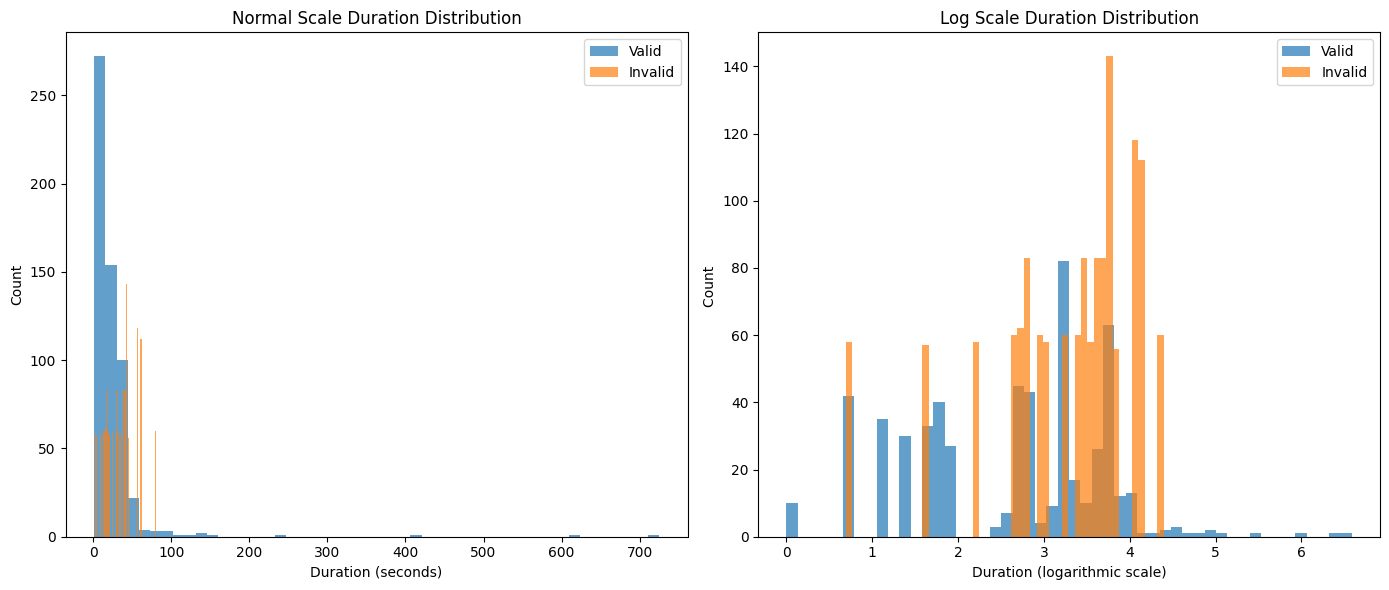

In [6]:
# checking normal and logarithmic duration distribution for valid and invalid data side by side with two classes in one plotimport matplotlib.pyplot as plt
import numpy as np


def plot_duration_distribution(data):
    """
    Plots duration histograms for valid and invalid instances side by side,
    one using a normal scale and one using a logarithmic scale.

    Parameters:
        data (pd.DataFrame): DataFrame containing at least "duration" and "is_valid" columns.
    """
    # Split durations
    valid_durations = data.loc[data["is_valid"] == 1, "duration"]
    invalid_durations = data.loc[data["is_valid"] == 0, "duration"]

    plt.figure(figsize=(14, 6))

    # Normal scale histogram
    plt.subplot(1, 2, 1)
    plt.hist(valid_durations, bins=50, alpha=0.7, label="Valid")
    plt.hist(invalid_durations, bins=50, alpha=0.7, label="Invalid")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Count")
    plt.title("Normal Scale Duration Distribution")
    plt.legend()

    # Logarithmic scale histogram
    plt.subplot(1, 2, 2)
    plt.hist(np.log(valid_durations), bins=50, alpha=0.7, label="Valid")
    plt.hist(np.log(invalid_durations), bins=50, alpha=0.7, label="Invalid")
    plt.xlabel("Duration (logarithmic scale)")
    plt.ylabel("Count ")
    plt.title("Log Scale Duration Distribution")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the function on your final_data DataFrame.
plot_duration_distribution(final_data)

## Product Configurations

In [7]:
import pandas as pd
from collections import Counter
import json

# exclude both for sim and real data part_id of -1
sim_data = sim_data[sim_data["part_id"] != -1]
real_data = real_data[real_data["part_id"] != -1]


def get_order_config(df):
    # Load the part mapping
    with open("output/part_mapping.json", "r") as f:
        part_mapping = json.load(f)

    # Invert the part mapping for easier lookup
    id_to_part = {v: k for k, v in part_mapping.items()}

    # Group part IDs by order ID
    order_configurations = df.groupby("order_id")["part_id"].apply(set).to_dict()

    # Convert part IDs to names
    order_configurations_named = {
        order_id: [id_to_part[part_id] for part_id in part_ids]
        for order_id, part_ids in order_configurations.items()
    }
    return order_configurations_named


def analyze_configurations(config_dict):
    # Convert configurations to tuples for hashability
    configs = [tuple(sorted(config)) for config in config_dict.values()]

    # Count configuration frequencies
    config_counts = Counter(configs)

    # Analyze component presence
    all_components = set(comp for config in configs for comp in config)

    print("Configuration Analysis for:")
    print("\n1. Configuration Frequencies:")
    for config, count in config_counts.most_common():
        print(f"  {list(config)}: {count} times")

    print("\n2. Component Presence:")
    for component in sorted(all_components):
        presence = sum(1 for config in configs if component in config)
        presence_percentage = (presence / len(configs)) * 100
        print(f"  {component}: {presence} times ({presence_percentage:.2f}%)")

    print("\n3. Configuration Complexity:")
    component_counts = [len(config) for config in configs]
    print(f"  Minimum Components: {min(component_counts)}")
    print(f"  Maximum Components: {max(component_counts)}")
    print(f"  Average Components: {sum(component_counts)/len(component_counts):.2f}")


config_sim_data = get_order_config(sim_data)
config_real_data = get_order_config(real_data)

print(analyze_configurations(config_sim_data))
print(analyze_configurations(config_real_data))

Configuration Analysis for:

1. Configuration Frequencies:
  ['analog', 'cover', 'display', 'gyroscope', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']: 56 times
  ['analog', 'cover', 'display', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']: 2 times
  ['cover', 'gyroscope', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']: 2 times
  ['cover', 'rass1', 'rass2', 'rass3', 'stopper']: 2 times

2. Component Presence:
  analog: 58 times (93.55%)
  cover: 62 times (100.00%)
  display: 58 times (93.55%)
  gyroscope: 58 times (93.55%)
  pcb: 60 times (96.77%)
  rass1: 62 times (100.00%)
  rass2: 62 times (100.00%)
  rass3: 62 times (100.00%)
  stopper: 62 times (100.00%)

3. Configuration Complexity:
  Minimum Components: 5
  Maximum Components: 9
  Average Components: 8.77
None
Configuration Analysis for:

1. Configuration Frequencies:
  ['analog', 'cover', 'display', 'gyroscope', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']: 193 times
  ['stopper']: 80 times
  ['rass3']: 17 times
  ['cover', 'rass3'

## Train Test Split

In [8]:
# Drop duration outliers where np.log(duration) >= 5
final_data = final_data[np.log(final_data["duration"]) < 5]

# Train Test Split
X = final_data.drop(columns=["is_valid", "start_time", "end_time", "order_id"])
y = final_data["is_valid"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Plotting Utils

In [9]:
# REPORTING UTILITY

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


def generate_report(y_true, y_pred, y_proba):
    """
    Generates a detailed report of binary classifier performance.

    Args:
        y_true (array-like): True target labels.
        y_pred (array-like): Predicted class labels.
        y_proba (array-like): Probabilities for the positive class.
    """
    # Print classification report and key metrics
    report = classification_report(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Classification Report:")
    print(report)
    print("Accuracy: {:.2f}".format(accuracy))
    print("ROC AUC: {:.2f}".format(auc))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f1))

    # Compute confusion matrix and ROC curve
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_proba)

    # Create subplots for Confusion Matrix and ROC Curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot confusion matrix
    im = ax1.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax1.figure.colorbar(im, ax=ax1)
    ax1.set(
        xticks=np.arange(2),
        yticks=np.arange(2),
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"],
        title="Confusion Matrix",
        ylabel="True label",
        xlabel="Predicted label",
    )
    # Loop over data dimensions and add text annotations.
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    # Plot ROC curve
    ax2.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = {:.2f})".format(auc),
    )
    ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Model")
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("Receiver Operating Characteristic (ROC)")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

## Decision Tree Classifier (no sequential effects)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       277
           1       1.00      0.83      0.91       118

    accuracy                           0.95       395
   macro avg       0.97      0.92      0.94       395
weighted avg       0.95      0.95      0.95       395

Accuracy: 0.95
ROC AUC: 0.99
Precision: 1.00
Recall: 0.83
F1-score: 0.91


<Figure size 6000x3000 with 0 Axes>

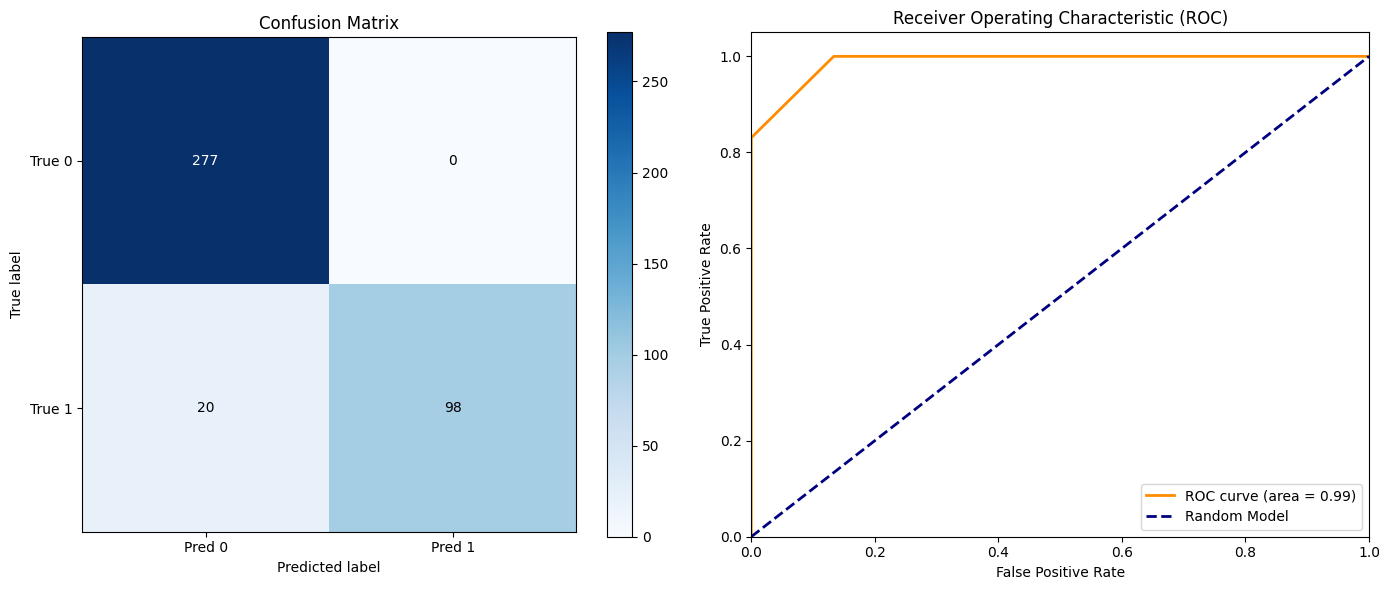

'decision_tree.pdf'

In [14]:
from sklearn.tree import DecisionTreeClassifier


plt.figure(figsize=(20, 10), dpi=300)


dt = DecisionTreeClassifier(random_state=683, max_depth=5)


dt.fit(X_train, y_train)


y_pred = dt.predict(X_test)


y_proba = dt.predict_proba(X_test)[:, 1]


generate_report(y_test, y_pred, y_proba)


from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to a Graphviz dot file
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=X.columns,
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    special_characters=True,
)

# Render the graph using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saves to a file
graph.view()  # Opens the tree in a viewer

## BiLSTM (Sequential Effects)

Initialized BiLSTMDataset with samples: 1561
Initialized BiLSTMDataset with samples: 377
CUDA IS AVAILABLE? True
Train dataset size: 1561
df_train_mod shape: (1579, 7)


c:\Users\danie\miniforge3\envs\ofact\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
c:\Users\danie\miniforge3\envs\ofact\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/150, Loss: 40.4518
Epoch 2/150, Loss: 29.8723
Epoch 3/150, Loss: 28.0955
Epoch 4/150, Loss: 24.7745
Epoch 5/150, Loss: 21.9411
Epoch 6/150, Loss: 20.4759
Epoch 7/150, Loss: 20.6636
Epoch 8/150, Loss: 16.1822
Epoch 9/150, Loss: 16.5431
Epoch 10/150, Loss: 17.3901
Epoch 11/150, Loss: 14.0042
Epoch 12/150, Loss: 14.6463
Epoch 13/150, Loss: 14.1654
Epoch 14/150, Loss: 13.3660
Epoch 15/150, Loss: 12.4459
Epoch 16/150, Loss: 10.9790
Epoch 17/150, Loss: 15.3621
Epoch 18/150, Loss: 10.9479
Epoch 19/150, Loss: 11.2612
Epoch 20/150, Loss: 10.8064
Epoch 21/150, Loss: 8.5361
Epoch 22/150, Loss: 10.0161
Epoch 23/150, Loss: 7.7544
Epoch 24/150, Loss: 3.6402
Epoch 25/150, Loss: 0.9794
Epoch 26/150, Loss: 2.5033
Epoch 27/150, Loss: 3.3233
Epoch 28/150, Loss: 3.6143
Epoch 29/150, Loss: 1.0580
Epoch 30/150, Loss: 0.0255
Epoch 31/150, Loss: 0.0267
Epoch 32/150, Loss: 0.0227
Epoch 33/150, Loss: 0.0095
Epoch 34/150, Loss: 0.0068
Epoch 35/150, Loss: 0.0020
Epoch 36/150, Loss: 0.0024
Epoch 37/150, Lo

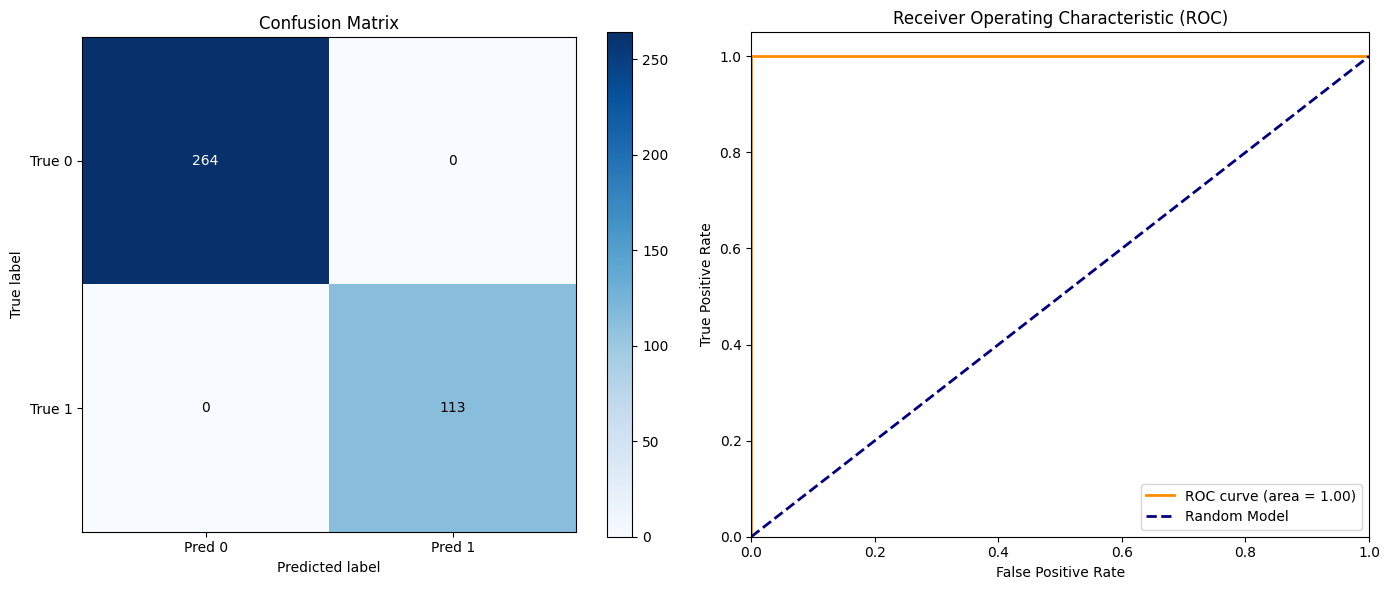

Model saved.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from typing import List, Tuple, Dict
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, classification_report

# 683 best so far
SEED = 683
torch.manual_seed(SEED)
np.random.seed(SEED)


class BiLSTM(nn.Module):
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, attention_heads: int
    ):
        super(BiLSTM, self).__init__()

        self.lstm_layers = nn.ModuleList(
            [
                nn.LSTM(
                    input_size if i == 0 else hidden_size * 2,
                    hidden_size,
                    batch_first=True,
                    dropout=0.3,  # use 0.5 for higher robustness doesnt harm performance
                    bidirectional=True,
                )
                for i in range(num_layers)
            ]
        )

        self.attention_layers = nn.ModuleList(
            [
                nn.MultiheadAttention(hidden_size * 2, attention_heads)
                for _ in range(num_layers)
            ]
        )

        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.residual = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        for i, lstm_layer in enumerate(self.lstm_layers):
            x, _ = lstm_layer(x)
            x = x.transpose(0, 1)
            x, _ = self.attention_layers[i](x, x, x)
            x = x.transpose(0, 1)
            x = self.layer_norm(x)
            residual = self.residual(x)
            x = F.relu(x + residual)
        x = torch.mean(x, dim=1)
        return torch.sigmoid(self.fc(x))


class BiLSTMDataset(Dataset):
    def __init__(self, df, sequence_length):
        self.sequence_length = sequence_length
        self.data = df.copy()
        self.samples = []  # list to store samples
        for i in range(len(df) - sequence_length + 1):
            self.samples.append(df.iloc[i : i + sequence_length])

        print("Initialized BiLSTMDataset with samples:", len(self.samples))

        # Define feature and target columns (make sure these exist in your DataFrame)
        self.feature_columns = [
            "duration",
            "part_id",
            "process_type",
            "process_id",
            "resource_id",
            "sequence_number",
        ]
        self.target_column = "is_valid"

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_df = self.samples[idx]
        # Convert features to float32 explicitly
        features = (
            sample_df[self.feature_columns].astype(float).values.astype(np.float32)
        )
        # Use the first target value; cast to int
        target = int(sample_df[self.target_column].values[0])
        return (
            torch.tensor(features, dtype=torch.float32),
            torch.tensor(target, dtype=torch.long),
        )


def train_model(
    model: BiLSTM,
    dataloader: DataLoader,
    num_epochs: int = 10,
    learning_rate: float = 0.0009964297013672556,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set up LR scheduler on plateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.1,
        patience=5,
        verbose=True,
    )

    criterion = torch.nn.BCELoss()
    loss_history = []
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Update the LR scheduler based on the epoch loss
        scheduler.step(epoch_loss)

    return loss_history


def evaluate_model(
    model: BiLSTM,
    dataloader: DataLoader,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> Dict[str, float]:
    model.to(device)
    model.eval()
    correct, total = 0, 0
    all_labels, all_probs = [], []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences).squeeze(1)
            predicted = (
                outputs > 0.9
            ).float()  # Hoher Wert um False Positives zu vermeiden => Anomalieerkennung
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_probs.extend(outputs.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    accuracy = correct / total if total > 0 else 0.0
    roc_auc = roc_auc_score(all_labels, all_probs)
    return {"accuracy": accuracy, "roc_auc": roc_auc}


def collate_fn(
    batch: List[Tuple[torch.Tensor, torch.Tensor]]
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Unpack the batch
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels_tensor = torch.stack(labels)
    return sequences_padded, labels_tensor


def diagnose_model(
    loss_history: List[float],
    accuracy: float,
    loss_threshold: float = 0.5,
    acc_threshold: float = 0.8,
) -> None:
    if loss_history and loss_history[-1] > loss_threshold:
        print("Warning: High loss, potential underfitting.")
    if accuracy < acc_threshold:
        print("Warning: Low accuracy, model may not capture process structure well.")
    if len(loss_history) >= 5 and (loss_history[0] - loss_history[-1]) < 0.1:
        print("Warning: Loss not decreasing significantly, possible underfitting.")


# Start the model

df_train_mod = pd.concat([X_train, y_train], axis=1)
df_test_mod = pd.concat([X_test, y_test], axis=1)
# Prepare the datasets
train_dataset = BiLSTMDataset(df_train_mod, sequence_length=19)
test_dataset = BiLSTMDataset(df_test_mod, sequence_length=19)

# Create the dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)
print("CUDA IS AVAILABLE?", torch.cuda.is_available())
# Print the train dataset size
print("Train dataset size:", len(train_dataset))

# Print the shape and head of df_train_mod
print("df_train_mod shape:", df_train_mod.shape)


# Initialize the model
model = BiLSTM(input_size=6, hidden_size=512, num_layers=1, attention_heads=4)

# Train the model
loss_history = train_model(model, train_loader, num_epochs=150)

# Evaluate the model
metrics = evaluate_model(model, test_loader)
print("Test Accuracy:", metrics["accuracy"])
print("Test ROC AUC:", metrics["roc_auc"])

# Diagnose the model
diagnose_model(loss_history, metrics["accuracy"])


def evaluate_model_with_preds(
    model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences).squeeze(1)
            probs = outputs.cpu().numpy().tolist()
            preds = (
                (outputs > 0.9).float().cpu().numpy().tolist()
            )  # Optimal Threshold by Youden's J
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy().tolist())
    return all_labels, all_preds, all_probs


# Evaluate and get predictions
all_labels, all_preds, all_probs = evaluate_model_with_preds(model, test_loader)

# Generate a detailed report
generate_report(all_labels, all_preds, all_probs)


# Save the model
model = torch.save(model.state_dict(), "BiLSTM_model.pth")
print("Model saved.")

## Diskrepanzen

Zwischenfazit: Der DT deckt gnadenlos Schwächen in der Simulatuon auf. Er erkennt zum Beispiel, dass bestimmte Resourcen bei der Simulation vorkommen, die in der Realität nicht vorkommen. 

TODO: Mappings kongruent machen, es dürfen nur IDs in beiden vorkommen die beide Nutzen. Im realen Fall müssen diese dann exkludiert werden. Es dürfen nur Prozesse vorkommen, die auch in der Sim vorkommen.

Hier sind einige auffällige Diskrepanzen und fehlende Kategorien in den Daten:

### **1. `order_id` Diskrepanzen**
- Die `order_id`s im `is_valid == 0` Bereich sind im niedrigen Bereich (z. B. 305, 328, 353), während im `is_valid == 1` Bereich die IDs viel höher sind (z. B. 3814, 3998, 4008).
- `is_valid == 0` hat 62 eindeutige `order_id`s, während `is_valid == 1` 112 hat → Potenzielle Datenverzerrung.
- Mögliches Problem: Verschiedene `order_id`-Bereiche könnten auf eine unterschiedliche Datenherkunft oder eine nicht konsistente Zuweisung hindeuten.

---

### **2. `start_time` und `end_time` Diskrepanzen**
- `is_valid == 0`: Alle `start_time`- und `end_time`-Werte stammen aus **2025**.
- `is_valid == 1`: Werte verteilen sich auf **2022 und 2023**.
- Mögliche Ursache: Unterschiedliche Zeiträume könnten auf eine Änderung im Datenerfassungsprozess hinweisen. Sind neuere Daten möglicherweise fehlerhaft?

---

### **3. `duration` Diskrepanzen**
- `is_valid == 0`: Sehr viele niedrige `duration`-Werte, häufige Wiederholungen (z. B. 43.0, 40.0, 17.0).
- `is_valid == 1`: Deutlich mehr verschiedene Werte, mit einigen extrem hohen `duration`-Werten (bis 64088.0!).
- Mögliches Problem: Unterschiedliche Berechnung der `duration`? Unterschiedliche Prozesse?

---

### **4. `part_id` Unterschiede**
- `is_valid == 0`: `part_id`s reichen von -1 bis 8.
- `is_valid == 1`: Mehr `part_id`s (bis 14!), mit `-1` als häufigstem Wert.
- Mögliche Ursache: Einige `part_id`s fehlen im `is_valid == 0`-Bereich → Unterschiedliche Datenquellen oder Filtermechanismen.

---

### **5. `process_type` Unterschiede**
- `is_valid == 0`: Werte sind 0, 1, -1, 2.
- `is_valid == 1`: Zusätzlich `process_type == 3`.
- Mögliche Ursache: Ein neuer Prozess wurde eingeführt und ist nicht in den ungültigen (`is_valid == 0`) Daten vorhanden?

---

### **6. `process_id` Unterschiede**
- `is_valid == 0`: Meist Werte zwischen 0 und 23.
- `is_valid == 1`: Werte zwischen 0 und **73** (mehr als 50 neue `process_id`s!).
- Mögliche Ursache: Ältere Prozesse fehlen in `is_valid == 1`, oder neuere Prozesse sind nicht im `is_valid == 0`-Bereich erfasst.

---

### **7. `resource_id` Unterschiede**
- `is_valid == 0`: Werte reichen von 0 bis 8.
- `is_valid == 1`: Werte reichen von 0 bis **13**.
- Mögliche Ursache: Ressourcen wurden möglicherweise später erweitert oder unterschiedliche Datenquellen wurden kombiniert.

---

### **Zusammenfassung der Anomalien**
✅ **Häufig fehlen bestimmte IDs in einem der beiden Sets** → Möglicher Hinweis auf selektive Datenverarbeitung.  
✅ **Zeitstempel haben komplett unterschiedliche Jahre** → Mögliche Probleme mit der Datenhistorie oder fehlerhafte Datenerfassung.  
✅ **Prozess-IDs und Ressourcentypen unterscheiden sich stark** → Möglichkeit einer Änderung der Geschäftsprozesse über die Zeit.  

**Frage:**  
🔍 Ist `is_valid` eine Art Klassifikationsmerkmal für neue vs. alte Daten, oder zeigt es fehlerhafte Werte an? Das würde helfen, die Ursache der Diskrepanzen besser zu verstehen.

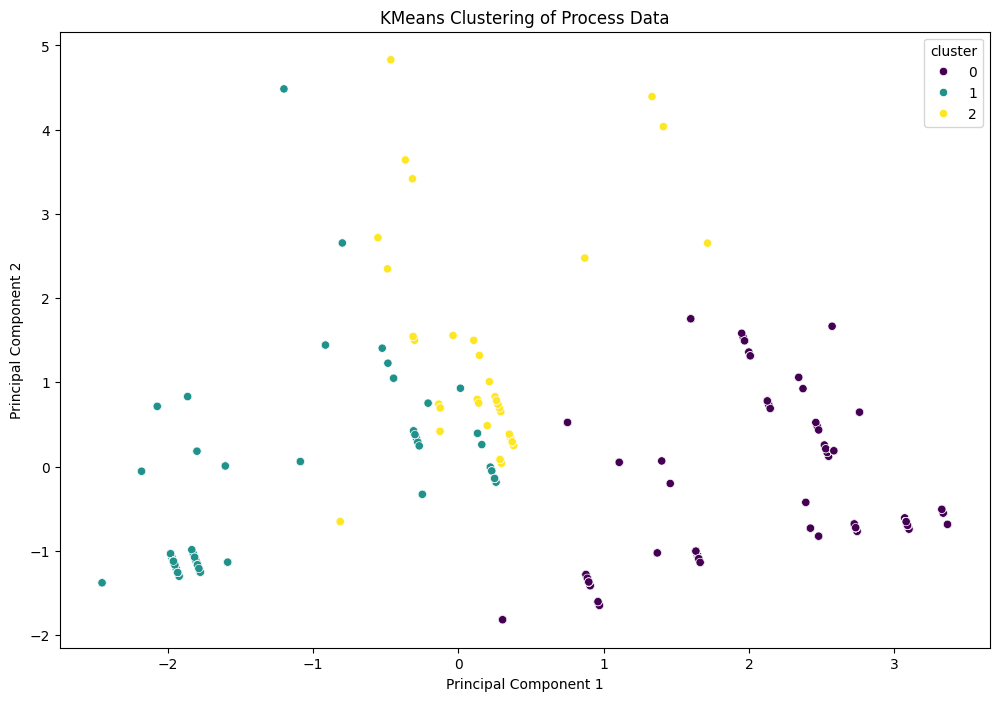

In [12]:
# Product clustering based on final_data

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot
import seaborn

# Select the features for clustering
features = [
    "duration",
    "part_id",
    "process_type",
    "process_id",
    "resource_id",
    "sequence_number",
]

# Standardize the features
scaler = StandardScaler()
final_data_scaled = scaler.fit_transform(final_data[features])

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
final_data_pca = pca.fit_transform(final_data_scaled)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
final_data["cluster"] = kmeans.fit_predict(final_data_scaled)

# Plot the clusters
plt.figure(figsize=(12, 8))
seaborn.scatterplot(
    x=final_data_pca[:, 0],
    y=final_data_pca[:, 1],
    hue=final_data["cluster"],
    palette="viridis",
)
plt.title("KMeans Clustering of Process Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()